In [ ]:
# This is an example GPT style decoder only transformer model and example dataset
# This an example of the use of the icanswim/cosmosis repo for data science and 
# machine learning projects

In [1]:
import sys # required for relative imports in jupyter lab
sys.path.insert(0, '../')

from torch.nn import CrossEntropyLoss
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau

from cosmosis.dataset import AsTensor
from cosmosis.learning import Learn, Selector, Metrics
from cosmosis.model import GPT

from dataset import TinyShakes

In [2]:
# explore the ds

ds_param = {'transforms': {'tokens': [AsTensor()],
                           'y': [AsTensor()],
                           'position': [AsTensor()]},
            'd_seq': 10,
            'n': 5}

ts = TinyShakes(**ds_param)

print(ts[0])
print(ts[0]['tokens'].shape, ts[0]['tokens'].dtype)
print(ts[0]['y'].shape, ts[0]['y'].dtype)
print('decoded tokens: ', ts.encoding.decode(ts[0]['tokens'].tolist()))
print('decoded y: ', ts.encoding.decode(ts[0]['y'].tolist()))


tinyshakes.txt loaded from saved file in ../gpt/data/
tokens loaded from file ./data/tinyshakes_stripped_encoded.bin
len(self.ds_idx):  5
data.nbytes:  602664
CDataset created...
{'tokens': tensor([ 5962, 22307,    25,  7413,   356,  5120,   597,  2252,    11,  3285]), 'y': tensor([22307,    25,  7413,   356,  5120,   597,  2252,    11,  3285,   502]), 'position': tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])}
torch.Size([10]) torch.int64
torch.Size([10]) torch.int64
decoded tokens:  First Citizen: Before we proceed any further, hear
decoded y:   Citizen: Before we proceed any further, hear me


In [3]:
# example using prompt for inference

ds_param = {'transforms': {'tokens': [AsTensor()],
                           'y': [AsTensor()],
                           'position': [AsTensor()]},
            'prompt': 'First Citizen: Before we proceed any further, hear '}

prompt = TinyShakes(**ds_param)
print(prompt[0])
print(prompt[0]['tokens'].shape)
# y wont be used in inference but is generated automatically 
# as part of the reuse of the getitem machinery
print(prompt[0]['y'].shape) 
print('decoded tokens: ', prompt.encoding.decode(prompt[0]['tokens'].tolist()))
print('decoded y: ', prompt.encoding.decode(prompt[0]['y'].tolist()))

len(self.ds_idx):  1
data.nbytes:  22
CDataset created...
{'tokens': tensor([ 5962, 22307,    25,  7413,   356,  5120,   597,  2252,    11,  3285,
          220]), 'y': tensor([22307,    25,  7413,   356,  5120,   597,  2252,    11,  3285,   220]), 'position': tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10])}
torch.Size([11])
torch.Size([10])
decoded tokens:  First Citizen: Before we proceed any further, hear 
decoded y:   Citizen: Before we proceed any further, hear 


In [4]:
# pass a single example from dataset to model to loss function
# (batch, d_seq, d_model)

d_seq = 3 # dimension sequence
d_vocab = 50304 # dimension vocabulary
d_vec = 4 # dimension embedding vector
d_model = 4 # dimension model input

assert d_model == d_vec

ds_param = {'transforms': {'tokens': [AsTensor()],
                           'y': [AsTensor()],
                           'position': [AsTensor()]},
            'd_seq': d_seq,
            'n': 5}

ts = TinyShakes(**ds_param)

print(ts[0])
print(ts[0]['tokens'].shape, ts[0]['tokens'].dtype)
print(ts[0]['y'].shape, ts[0]['y'].dtype)
print('decoded tokens: ', ts.encoding.decode(ts[0]['tokens'].tolist()))
print('decoded y: ', ts.encoding.decode(ts[0]['y'].tolist()))

model_param = {'device': 'cpu',
               'd_model': d_model, # matches embedding dimension
               'd_vocab': d_vocab, 
               'n_head': 2, 
               'num_layers': 2,
               'd_seq': d_seq,
               'd_vec': d_vec,
               'embed_param': {'tokens': (d_vocab, d_vec, None, True), 
                               'y': (d_vocab, d_vec, None, True),
                               'position': (d_seq, d_vec, None, True)}} 

gpt = GPT(model_param)

data = ts[0]
out = gpt(data)
print('output: ', out, out.shape, out.dtype)

prompt_tokens = data['tokens']
print('prompt_tokens: ', prompt_tokens, prompt_tokens.shape, prompt_tokens.dtype)

target_tokens = data['y']
print('target_tokens: ', target_tokens, target_tokens.shape, target_tokens.dtype)

generated_embeddings = out.squeeze()
print('generated_embeddings: ', generated_embeddings, generated_embeddings.shape, generated_embeddings.dtype)
print('decoded generated tokens: ', prompt.encoding.decode(generated_embeddings.argmax(dim=-1).tolist()))

cel_func = CrossEntropyLoss()
loss = cel_func(out, target_tokens)
print('loss: ', loss)


tinyshakes.txt loaded from saved file in ../gpt/data/
tokens loaded from file ./data/tinyshakes_stripped_encoded.bin
len(self.ds_idx):  5
data.nbytes:  602664
CDataset created...
{'tokens': tensor([ 5962, 22307,    25]), 'y': tensor([22307,    25,  7413]), 'position': tensor([0, 1, 2])}
torch.Size([3]) torch.int64
torch.Size([3]) torch.int64
decoded tokens:  First Citizen:
decoded y:   Citizen: Before
applying _init_weights...
GPT model loaded...
number of model parameters:  201220
output:  tensor([[ 0.0069,  0.0168,  0.0580,  ..., -0.0273,  0.0639, -0.0131],
        [-0.0019,  0.0078,  0.0237,  ..., -0.0403,  0.0652,  0.0063],
        [-0.0422,  0.0211,  0.0521,  ..., -0.0379,  0.0138, -0.0096]],
       grad_fn=<MmBackward0>) torch.Size([3, 50304]) torch.float32
prompt_tokens:  tensor([ 5962, 22307,    25]) torch.Size([3]) torch.int64
target_tokens:  tensor([22307,    25,  7413]) torch.Size([3]) torch.int64
generated_embeddings:  tensor([[ 0.0069,  0.0168,  0.0580,  ..., -0.0273,  0.0

tinyshakes.txt loaded from saved file in ../gpt/data/
tokens loaded from file ./data/tinyshakes_stripped_encoded.bin
len(self.ds_idx):  1000
data.nbytes:  602664
CDataset created...
applying _init_weights...
GPT model loaded...
number of model parameters:  38634240
running model on gpu...

.....................

total elapsed time: 0:00:13.351613
epoch: 1
y_pred:   wounds Bre low shapesud abort sleek falling Pad slow MIS Gard stumble blank distressedser side Whe almostring TH speakingyour pack seldomert fairy urged worn arrested themselves Came castcrow rapjuries Watchinguddy breathed Pe puts wars wors twenty riot pause preyinn frost loyal curses wheels pen wondersportionared gottenels strict North P crush leaving PlainOV requiresusedirs told bondage numbers witchcraftidsities Tid designeps meaningalled leap mount Hoo Belg hours line dancing post liaroke poets understand Com Tend extrem studying pounds days Le cour Setting
y:   come.  AUFIDIUS: The town is ta'en!  First Soldier: 'Twill

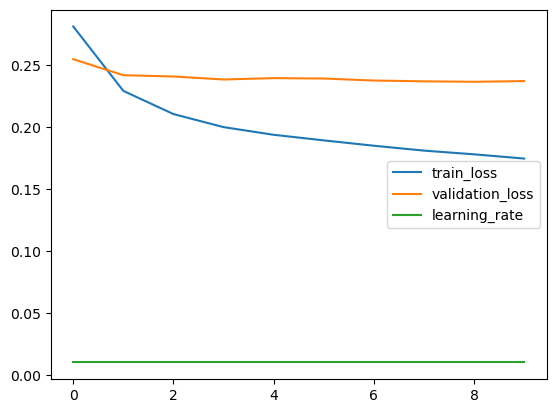

model: tinyshakes512 saved...


In [3]:
# put all together in a learner
# (batch, d_seq, d_model)

d_seq = 100 # dimension sequence
d_vocab = 50304 # dimension vocabulary
d_vec = 768 # dimension embedding vector
d_model = 768 # dimension model input
assert d_model == d_vec

ds_param = {'train_param': {'transforms': {'tokens': [AsTensor()],
                            'y': [AsTensor()],
                            'position': [AsTensor()]},
            'd_seq': d_seq,
            'n': 1000,
                           }}

model_param = {'d_model': d_model,
               'd_vocab': d_vocab, 
               'n_head': 12, 
               'num_layers': 12,
               'd_seq': d_seq,
               'd_vec': d_vec,
               'embed_param': {'tokens': (d_vocab, d_vec, None, True), 
                               'y': (d_vocab, d_vec, None, True),
                               'position': (d_seq, d_vec, None, True)}} 
                                       
metrics_param = {'metric_name': 'transformer',
                 'report_interval': 1,
                 'log_plot': False,
                 'min_lr': .0025} # break if learning rate falls below                        
             
opt_param = {'lr': 0.01}

crit_param = {}

sample_param = {'set_seed': 88,
                'splits': (.7,.15)}

sched_param = {'factor': .5, 
               'patience': 2,
               'cooldown': 2}

learn = Learn([TinyShakes], 
              GPT,
              Metrics=Metrics,
              Sampler=Selector, 
              Optimizer=Adam, 
              Scheduler=ReduceLROnPlateau, 
              Criterion=CrossEntropyLoss,
              model_param=model_param, ds_param=ds_param, sample_param=sample_param,
              opt_param=opt_param, sched_param=sched_param, crit_param=crit_param,
              metrics_param=metrics_param, 
              batch_size=32, epochs=10, gpu=True, 
              save_model='tinyshakes512', load_model=None, target='y')

In [7]:
# inference
d_gen = 50 # dimension generate number of tokens
d_vocab = 50304 # dimension vocabulary
d_vec = 128 # dimension embedding vector
d_model = 128 # dimension model input
d_pos = 50 # dimension positional encoding d_pos >= max(len(prompt_tokens), d_gen)

assert d_model == d_vec


ds_param = {'train_param': {'transforms': {'tokens': [AsTensor()],
                            'y': [AsTensor()],
                            'position': [AsTensor()]},
            'prompt': 'You may partake of any thing we say \
We speak no treason man we say the king'}}

model_param = {'d_model': d_model,
               'd_vocab': d_vocab, 
               'n_head': 8, 
               'num_layers': 6,
               'd_gen': d_gen,
               'd_vec': d_vec,
               'temperature': 1,
               'embed_param': {'tokens': (d_vocab, d_vec, None, True), 
                               #'y': (d_vocab, d_vec, None, True),
                               'position': (d_pos, d_vec, None, True)}} 
                                       
metrics_param = {'metric_name': 'transformer'}                        
             
opt_param = {}

crit_param = {}

sample_param = {}

sched_param = {}

learn = Learn([TinyShakes], 
              GPT,
              Metrics=Metrics,
              Sampler=Selector, 
              Optimizer=None, 
              Scheduler=None, 
              Criterion=None, # no criterion implies inference
              model_param=model_param, ds_param=ds_param, sample_param=sample_param,
              opt_param=opt_param, sched_param=sched_param, crit_param=crit_param,
              metrics_param=metrics_param, 
              batch_size=1, epochs=3, gpu=True, 
              load_model='tinyshakes128.pth', target=None)


len(self.ds_idx):  1
data.nbytes:  34
CDataset created...
applying _init_weights...
GPT model loaded...
model loaded from state_dict...
running model on gpu...

.....................

total learning time: 0:00:00.153667
predictions:  [[' nodded myantine myIOUSUS lordoth protest L ceremonies  actsconCISISUU,   golden AD politicsribesconconYR Alvin Intellectualcastsningsside animal Unleashed caught Quite colder manipulating lucrative pilgr Employ intellectuals unusually official agric Lad sloppy']]
inference instance 2025-03-06 08:07:45.154228 complete and saved to csv...

.....................

total learning time: 0:00:00.170821
predictions:  [[' addressed my compose ofIOUSUS lord d conquest har ceremonies OLconCISISUSUS:US. Redmondع sporadic blastsESSalt En Closed Intellectual Intellectual Orbitalside examples connectors frivolous Quitestown Pole lucrative wildly shocks couples unusually officialBUG repaymentPi']]
inference instance 2025-03-06 08:07:45.171382 complete and saved to csv